In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
INIT_LR = 1e-4
EPOCHS = 2
BS = 73

DIRECTORY = r"D:\users\meyyappan\downloads\Face Mask Dataset"
CATEGORY = ["withmask", "withoutmask"]

In [3]:
print("[INFO] loading images from the dataset for splitting...")

data = []
label1 = []

for category in CATEGORY:
    path = os.path.join(DIRECTORY, category)
    for imgs in os.listdir(path):
        img_paths = os.path.join(path, imgs)
        image1 = load_img(img_paths, target_size=(224, 224))
        image1 = img_to_array(image1)
        image1 = preprocess_input(image1)
        
        data.append(image1)
        label1.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
label1 = lb.fit_transform(label1)
label1 = to_categorical(label1)


[INFO] loading images from the dataset for splitting...


In [4]:

data = np.array(data, dtype="float32")
label1 = np.array(label1)
(trainX, testX, trainY, testY) = train_test_split(data, label1,
    test_size=0.20, stratify=label1, random_state=42)



In [5]:

# Data augmentation
augmentation = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [6]:
# removing the top layer of the base model
base_Model = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# creating the head of the model
head_Model = base_Model.output
head_Model = AveragePooling2D(pool_size=(2, 2))(head_Model)
head_Model = Flatten(name="flatten")(head_Model)
head_Model = Dense(128, activation="relu")(head_Model)
head_Model = Dropout(0.5)(head_Model)
head_Model = Dense(2, activation="softmax")(head_Model)

In [7]:
# placing the head  model on top of the base model 
InceptionV3model = Model(inputs=base_Model.input, outputs=head_Model)

#looping over all layers to freeze the model
for layers in base_Model.layers:
    layers.trainable = False

# compiling the model
print("[INFO] compiling the model...")
optimize = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
InceptionV3model.compile(loss="binary_crossentropy", optimizer=optimize,
      metrics=["accuracy"])

[INFO] compiling the model...


D:\anaconda\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [8]:
 # trainning the model
print("[INFO] training the model...")
L = InceptionV3model.fit(
    augmentation.flow(trainX,trainY,batch_size=BS),
    steps_per_epoch=len(trainX)//BS,
    validation_data=(testX,testY),
    validation_steps=len(testX)//BS,
    epochs=EPOCHS)

[INFO] training the model...
Epoch 1/2
129/129 [==============================] - 453s 3s/step - loss: 0.1030 - accuracy: 0.9650 - val_loss: 0.0178 - val_accuracy: 0.9958
Epoch 2/2
129/129 [==============================] - 495s 4s/step - loss: 0.0373 - accuracy: 0.9889 - val_loss: 0.0129 - val_accuracy: 0.9958


In [9]:
print("[INFO] evaluating the model...")
predIdxs =InceptionV3model.predict(testX, batch_size=BS)

# for each and every image in the testing set, we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# printing the classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
     target_names=lb.classes_))

# saving the model
print("[INFO] saving mask detection model...")
InceptionV3model.save("mask_detection.model", save_format="h5")

[INFO] evaluating the model...
              precision    recall  f1-score   support

    withmask       1.00      0.99      1.00      1177
 withoutmask       0.99      1.00      1.00      1182

    accuracy                           1.00      2359
   macro avg       1.00      1.00      1.00      2359
weighted avg       1.00      1.00      1.00      2359

[INFO] saving mask detection model...


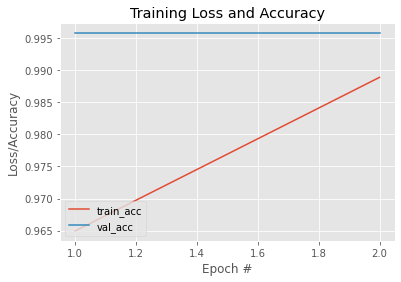

In [16]:
K= EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(1, K+1), L.history["accuracy"], label="train_acc")
plt.plot(np.arange(1, K+1), L.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

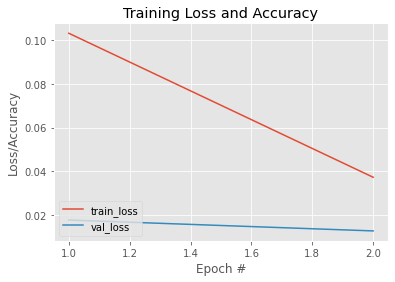

In [17]:
K= EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(1, K+1), L.history["loss"], label="train_loss")
plt.plot(np.arange(1, K+1), L.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

This image contains mask!!!


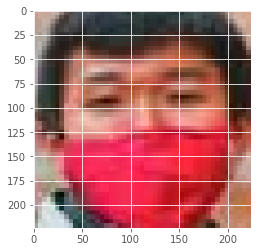

In [15]:
#print(predIdxs)
img12 =load_img(r'D:\users\meyyappan\downloads\Face Mask Dataset\withmask\5.png',target_size=(224,224))
plt.imshow(img12)
img12 = img_to_array(img12)
img12 = img12/255.0
img12 = np.expand_dims(img12,axis=0)
model1 = load_model('C:\\Users\\S Meyyappan\\mask_detection.model')
f=model1.predict(img12)
pred1 = np.argmax(f,axis=1)
if pred1[0] == 0:
    print("This image contains mask!!!")
else:
    print("This image doesn't contain mask!!!")